# Algorithmic Trading Model Development for BTC/USDT Crypto Market

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [41]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Datasets

In [19]:
df_3m = pd.read_csv('datasets/btc_3m.csv')
df_5m = pd.read_csv('datasets/btc_5m.csv')
df_15m = pd.read_csv('datasets/btc_15m.csv')
df_30m = pd.read_csv('datasets/btc_30m.csv')
df_30m = pd.read_csv('datasets/btc_30m.csv')
df_1h = pd.read_csv('datasets/btc_1h.csv')
df_2h = pd.read_csv('datasets/btc_2h.csv')
df_4h = pd.read_csv('datasets/btc_4h.csv')
df_6h = pd.read_csv('datasets/btc_6h.csv')

Adding technical indicators (MCDA-Signal Line, RSI, Bollinger bands, ATR, moving averages)

In [20]:
def add_indicators(df):
    # SMA
    df['SMA_14'] = df['close'].rolling(window=14).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()

    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Bollinger Bands
    window = 20
    df['Upper_Band'] = df['SMA_20'] + 2 * df['close'].rolling(window=window).std()
    df['Lower_Band'] = df['SMA_20'] - 2 * df['close'].rolling(window=window).std()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14
    df['EMA'] = df['close'].ewm(span=15, adjust=False).mean()
    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    short_window = 20  # Example: 20-minute moving average
    long_window = 50   # Example: 50-minute moving average
    df['short_ma'] = df['close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long-term moving average (long_ma)
    df['long_ma'] = df['close'].rolling(window=long_window, min_periods=1).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [21]:
df_3m = add_indicators(df_3m)
df_5m = add_indicators(df_5m)
df_15m = add_indicators(df_15m)
df_30m = add_indicators(df_30m)
df_30m = add_indicators(df_30m)
df_1h = add_indicators(df_1h)
df_2h = add_indicators(df_2h)
df_4h = add_indicators(df_4h)
df_6h = add_indicators(df_6h)

In [22]:
print(f"Shape of df_3m : {df_3m.shape}")
print(f"Shape of df_5m : {df_5m.shape}")
print(f"Shape of df_15m: {df_15m.shape}")
print(f"Shape of df_30m: {df_30m.shape}")
print(f"Shape of df_30m: {df_30m.shape}")
print(f"Shape of df_1h : {df_1h.shape}")
print(f"Shape of df_2h : {df_2h.shape}")
print(f"Shape of df_4h : {df_4h.shape}")
print(f"Shape of df_6h : {df_6h.shape}")

Shape of df_3m : (712973, 17)
Shape of df_5m : (427790, 17)
Shape of df_15m: (142591, 17)
Shape of df_30m: (71273, 17)
Shape of df_30m: (71273, 17)
Shape of df_1h : (35645, 17)
Shape of df_2h : (17823, 17)
Shape of df_4h : (8912, 17)
Shape of df_6h : (5940, 17)


Filtering dataset and adding previous n timesteps of data as separate columns for training the model

In [23]:
def preprocessor(df):
  start_date = '2018-01-01'
  end_date = '2019-12-01'

  # Filter the data
  df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

  num_timestamps = 10

  # Create new columns for each day
  for i in range(1, num_timestamps + 1):
      df[f'openday{i}']   = df['open'].shift(i)
      df[f'highday{i}']   = df['high'].shift(i)
      df[f'lowday{i}']    = df['low'].shift(i)
      df[f'closeday{i}']  = df['close'].shift(i)
      df[f'volumeday{i}'] = df['volume'].shift(i)
      df[f'rsiday{i}']    = df['RSI'].shift(i)
      df[f'EMAday{i}']    = df['EMA'].shift(i)

  # Drop rows with NaN values created by shifting
  df = df.dropna()

  # Drop the high low volume and rsi columns
  df = df.drop(['high', 'low', 'volume'], axis=1)

  return df


In [24]:
df_3m=preprocessor(df_3m)
df_5m=preprocessor(df_5m)
df_15m=preprocessor(df_15m)
df_30m=preprocessor(df_30m)
df_1h=preprocessor(df_1h)
df_2h=preprocessor(df_2h)
df_4h=preprocessor(df_4h)
df_6h=preprocessor(df_6h)

C:\Users\sanya\AppData\Local\Temp\ipykernel_19740\1352744991.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'openday{i}']   = df['open'].shift(i)
C:\Users\sanya\AppData\Local\Temp\ipykernel_19740\1352744991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'highday{i}']   = df['high'].shift(i)
C:\Users\sanya\AppData\Local\Temp\ipykernel_19740\1352744991.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Dividing into features and target (current close price)

In [48]:
features= ['open','EMA','RSI','openday1', 'highday1', 'lowday1', 'closeday1', 'volumeday1', 'rsiday1',
       'EMAday1', 'openday2', 'highday2', 'lowday2', 'closeday2', 'volumeday2',
       'rsiday2', 'EMAday2', 'openday3', 'highday3', 'lowday3', 'closeday3',
       'volumeday3', 'rsiday3', 'EMAday3', 'openday4', 'highday4', 'lowday4',
       'closeday4', 'volumeday4', 'rsiday4', 'EMAday4', 'openday5', 'highday5',
       'lowday5', 'closeday5', 'volumeday5', 'rsiday5', 'EMAday5']

target = 'close'

In [49]:
x_3m = df_3m[features]
y_3m = df_3m[target]

x_5m = df_5m[features]
y_5m = df_5m[target]

x_15m = df_15m[features]
y_15m = df_15m[target]

x_30m = df_30m[features]
y_30m = df_30m[target]

x_1h = df_1h[features]
y_1h = df_1h[target]

x_2h = df_2h[features]
y_2h = df_2h[target]

x_4h = df_4h[features]
y_4h = df_4h[target]

x_6h = df_6h[features]
y_6h = df_6h[target]


## Training models

Training a random forest regressor on each frequency

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle

def train(x,y,model_name=f"model_{datetime.datetime.now().timestamp()}"):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

  # Initialize the model
  model = RandomForestRegressor(max_features=None,n_estimators=250)

  # Train the model
  model.fit(X_train, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test)

  # Saving models
  filename = f'models/{model_name}.h5'

  with open(filename, 'wb') as f:
      pickle.dump(model, f)

  return model

In [39]:
model1=train(x_3m,y_3m,"model_3m")
model2=train(x_5m,y_5m,"model_5m")
model3=train(x_15m,y_15m,"model_15m")
model4=train(x_30m,y_30m,"model_30m")
model5=train(x_1h,y_1h,"model_1h")
model6=train(x_2h,y_2h,"model_2h")
model7=train(x_4h,y_4h,"model_4h")
model8=train(x_6h,y_6h,"model_6h")

KeyboardInterrupt: 

In [51]:
from datetime import datetime,timedelta

date = df_5m.iloc[1]['datetime']

date_object = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

# Get the minutes from the datetime object
minutes = date_object.minute
hours=date_object.hour


a=int(minutes/3)
b=int(minutes/15)
c=int(minutes/30)


aa=a*3+3
bb=b*15+15
cc=c*30+30

a1=aa-minutes
b1=bb-minutes
c1=cc-minutes



if minutes%3==0:
  date_3m=date
else:
  date_3m=(date_object+timedelta(minutes=a1)).strftime('%Y-%m-%d %H:%M:%S')

if minutes%15==0:
  date_15m=date
else:
  date_15m=(date_object+timedelta(minutes=b1)).strftime('%Y-%m-%d %H:%M:%S')

if minutes%30==0:
  date_30m=date
else:
  date_30m=(date_object+timedelta(minutes=c1)).strftime('%Y-%m-%d %H:%M:%S')

if minutes==30:
  date_1h=date
else:
  date_1h=(date_object+timedelta(hours=1)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')

if minutes==30 and hours%2==1:
  date_2h=date
else:
  date_2h=(date_object+timedelta(hours=2)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')
'''
if minutes==30 and hours%4==1:
  date_4h=date
else:
  date_4h=(date_object+timedelta(hours=4)).strftime('%Y-%m-%d %H:%M:%S')

if minutes==30 and hours%6==1:
  date_6h=date
else:
  date_6h=(date_object+timedelta(hours=6)).strftime('%Y-%m-%d %H:%M:%S')'''


print(date_3m)
print(date_15m)
print(date_30m)
print(date_1h)
print(date_2h)
#print(date_4h)
#print(date_6h)


2018-01-01 08:00:00
2018-01-01 08:00:00
2018-01-01 08:00:00
2018-01-01 09:30:00
2018-01-01 10:30:00


In [57]:
df_15m[(df_15m['datetime'] >= start_date) & (df_15m['datetime'] <= end_date)]

,datetime,open,close,SMA_14,SMA_20,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,...,volumeday9,rsiday9,EMAday9,openday10,highday10,lowday10,closeday10,volumeday10,rsiday10,EMAday10


<Figure size 1400x600 with 0 Axes>

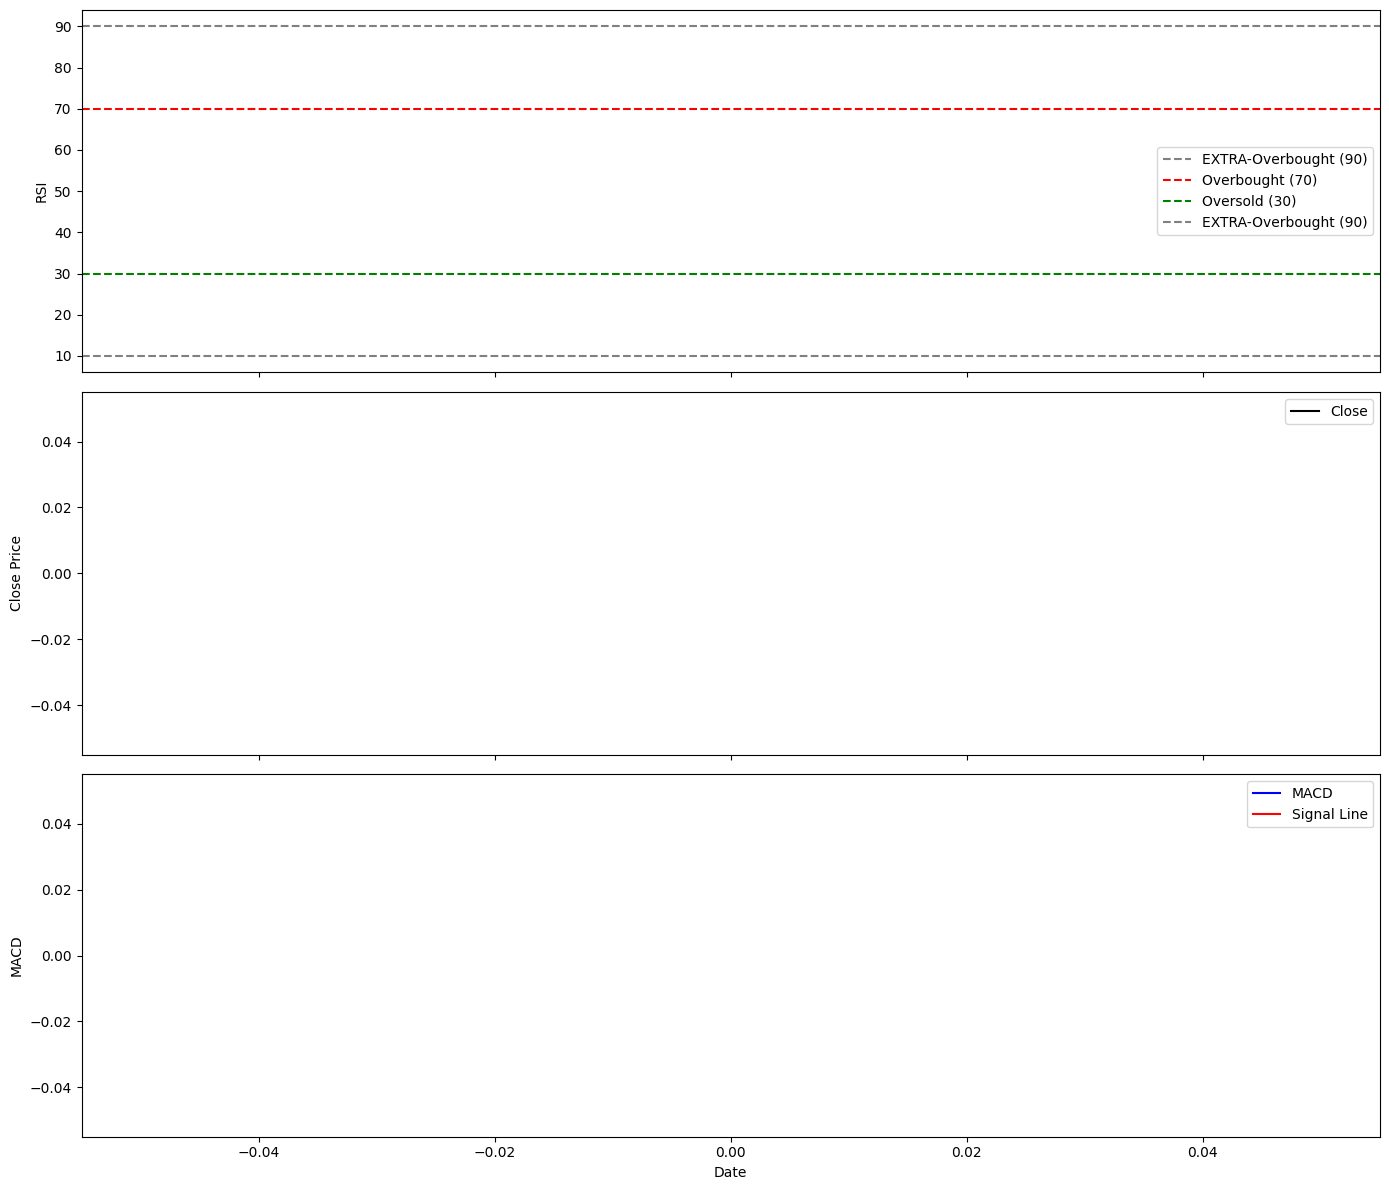

In [56]:
start_date = '2020-01-01'
end_date = '2020-01-30'

# Filter the data
s1 = df_15m[(df_15m['datetime'] >= start_date) & (df_15m['datetime'] <= end_date)]
# For understanding the indicators

plot_df = s1.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

## Trading loop

In [ ]:
balance_usdt = 10000
balance_btc = 0
stop_loss = balance_btc*(0.002)

for i in range(df_15m.shape[0]):
    # Current row
    current_row = df_15m[i]

    # get the date for the i th row
    date = df_15m.iloc[i]['datetime']

    date_object = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

    # Get the minutes from the datetime object
    minutes = date_object.minute
    hours=date_object.hour

    a=int(minutes/3)
    b=int(minutes/15)
    c=int(minutes/30)

    aa=a*3+3
    bb=b*15+15
    cc=c*30+30

    a1=aa-minutes
    b1=bb-minutes
    c1=cc-minutes

    if minutes%3==0:
      date_3m=date
    else:
      date_3m=(date_object+timedelta(minutes=a1)).strftime('%Y-%m-%d %H:%M:%S')

    if minutes%15==0:
      date_15m=date
    else:
      date_15m=(date_object+timedelta(minutes=b1)).strftime('%Y-%m-%d %H:%M:%S')

    if minutes%30==0:
      date_30m=date
    else:
      date_30m=(date_object+timedelta(minutes=c1)).strftime('%Y-%m-%d %H:%M:%S')

    if minutes==30:
      date_1h=date
    else:
      date_1h=(date_object+timedelta(hours=1)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')

    if minutes==30 and hours%2==1:
      date_2h=date
    else:
      date_2h=(date_object+timedelta(hours=2)).replace(minute=30, second=0).strftime('%Y-%m-%d %H:%M:%S')
        # Get the data for the date

    data_3m = df_15m[df_15m['datetime'] == date_3m]
    data_5m = df_15m[df_15m['datetime'] == date]
    data_15m = df_15m[df_15m['datetime'] == date_15m]
    data_30m = df_15m[df_15m['datetime'] == date_30m]
    data_1h = df_15m[df_15m['datetime'] == date_1h]
    data_2h = df_15m[df_15m['datetime'] == date_2h]

    # Get the feature vector for the date
    xp_3m = data_3m[features]
    xp_5m = data_5m[features]
    xp_15m = data_15m[features]
    xp_30m = data_30m[features]
    xp_1h = data_1h[features]
    xp_2h = data_2h[features]

    # Predict the price using the model
    y_pred_3m = model1.predict(xp_3m)
    y_pred_5m = model2.predict(xp_5m)
    y_pred_15m = model3.predict(xp_15m)
    y_pred_30m = model4.predict(xp_30m)
    y_pred_1h = model5.predict(xp_1h)
    y_pred_2h = model6.predict(xp_2h)
  

    # difference between the predicted close and actual open
    open=data_5m["open"].values[0]

    close_predicted=y_pred_3m[0]
    diff1 = close_predicted-open

    close_predicted=y_pred_5m[0]
    diff2 = close_predicted-open

    close_predicted=y_pred_15m[0]
    diff3 = close_predicted-open

    close_predicted=y_pred_30m[0]
    diff4 = close_predicted-open

    close_predicted=y_pred_1h[0]
    diff5 = close_predicted-open

    close_predicted=y_pred_2h[0]
    diff6 = close_predicted-open

    sum1=0

    if diff1>0:
        sum1=sum1+1
    if diff2>0:
        sum1=sum1+1
    if diff3>0:
        sum1=sum1+1
    if diff4>0:
        sum1=sum1+1

    sum2=0

    if diff5>0:
        sum2=sum2+1
    if diff6>0:
        sum2=sum2+1

    #  100% investment
    if sum1==4 and current_row['rsi']<30 and current_row['short_ma']>current_row['long_ma'] and  balance_usdt>0 and current_row['MACD'] > current_row['Signal_Line'] :
        btc=btc+((balance_usdt-0.0015*balance_usdt)/open)
        stop_loss = balance_usdt*(0.002)
        balance_btc=btc
        balance_usdt=0
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    #  75% investment
    elif sum1==3 and current_row['rsi']<30 and current_row['short_ma']>current_row['long_ma'] and balance_usdt>0 and current_row['MACD'] > current_row['Signal_Line'] :
        btc=btc + (((balance_usdt*(0.75))-0.0015*balance_usdt)/open)
        stop_loss = balance_usdt*0.75*(0.002)
        balance_btc=btc
        balance_usdt=balance_usdt*(0.25)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    #  50% investment
    elif sum1==2 and current_row['rsi']<30 and current_row['short_ma'] > current_row['long_ma'] and sum2>=2 :
        btc=btc+(((balance_usdt*(0.50))-0.0015*balance_usdt)/open)
        stop_loss = balance_usdt*0.50*(0.002)
        balance_btc=btc
        balance_usdt=balance_usdt*(0.50)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    #25% sell
    elif sum1>=0 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 :  # Changed this line
        usdt=balance_usdt+(balance_btc*0.25*open)
        balance_usdt=usdt-(0.0015*usdt)
        balance_btc=balance_btc*0.75
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    #50% sell
    elif sum1>=-2 and sum2>=-1 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 and current_row['MACD'] < current_row['Signal_Line'] :   # Changed this line
        usdt=balance_usdt+(balance_btc*0.5*open)
        balance_usdt=usdt-(0.0015*usdt)
        balance_btc=balance_btc*0.50
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    #75% sell
    elif sum1>=-3 and sum2>=-2 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 and current_row['MACD'] < current_row['Signal_Line'] :  # Changed this line
        usdt=balance_usdt+(balance_btc*0.75*open)
        balance_usdt=usdt-(0.0015*usdt)
        balance_btc=balance_btc*0.25
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    # 100% sell
    elif sum1==-4 and current_row['rsi']>70 and current_row['short_ma'] < current_row['long_ma'] and diff3 < (-stop_loss) and balance_btc>0 and current_row['MACD'] < current_row['Signal_Line'] :  # Changed this line
        usdt=balance_btc*open
        balance_usdt=usdt-(0.0015*usdt)
        balance_btc=0
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    else:
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')

    # If loop reached the end convert all btc to usd
    if i==df_15m.shape[0]-1 and balance_usdt==0:
        usdt=balance_btc*open
        balance_usdt=usdt
        balance_btc=0

# Print the final balances after executing the trades
print(f"Final Balances: USDT {balance_usdt}, BTC {balance_btc}")

In [ ]:
balance_usdt = 10000
balanceinv=balance_usdt*0.1
balance_btc = 0
stop_loss = balance_btc*(0.002)
signal=""
invested_amount = 0

for i in range(df_test.shape[0]):

    # get the date for the i th row
    date = df_test.iloc[i]['datetime']
    macd=df_test.iloc[i]['MACD']
    signalline=df_test.iloc[i]['Signal_Line']
    shortema=df_test.iloc[i]['short_ma']
    longema=df_test.iloc[i]['long_ma']

    # Get the data for the date
    data = df_test[df_test['datetime'] == date]

    # Get the feature vector for the date
    x = data[features]

    # Predict the price using the model
    y_pred = model.predict(x)

    # difference between the predicted close and actual open
    open=data["open"].values[0]
    close_predicted=y_pred[0]
    diff = close_predicted-open

    # Compare the predicted class with the actual class
    if diff > 0 and balance_usdt>0 and shortema>longema and macd>signalline:
        
        btc=balance_btc+((balance_usdt-0.0015*balance_usdt)/open) # ((balance_usdt)/open) #((balance_usdt-0.0015*balance_usdt)/open)
        stop_loss = balance_usdt*(0.002)
        balance_btc=btc
        balance_usdt=0
        signal="buy"
        update_df(i, balance_usdt, balance_btc, signal)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    elif diff > 0 and balance_usdt>0 and macd>signalline and shortema<longema:

      if balance_usdt<=balanceinv:
          btc=balance_btc+((balance_usdt-0.0015*balance_usdt)/open) # ((balance_usdt)/open) #((balance_usdt-0.0015*balance_usdt)/open)
          stop_loss = balance_usdt*(0.002)
          balance_btc=btc
          balance_usdt=0
      else:
          btc=balance_btc + (((balance_usdt*(0.75))-0.0015*balance_usdt)/open) #(((balance_usdt*(0.75)))/open) #(((balance_usdt*(0.75))-0.0015*balance_usdt)/open)
          stop_loss = balance_usdt*0.75*(0.0015)
          balance_btc=btc
          balance_usdt=balance_usdt*(0.25)
      signal="buy"
      update_df(i, balance_usdt, balance_btc, signal)
      print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')


    elif diff<0 and diff < (-stop_loss) and balance_btc>0  and shortema<longema and macd < signalline:  # Changed this line

        usdt=balance_usdt+((balance_btc-(0.0015*balance_btc))*open)
        balance_usdt=usdt -(0.001*usdt)
        balance_btc=0
        signal='sell'
        update_df(i, balance_usdt, balance_btc, signal)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

    elif diff<0  and balance_btc>0 and macd < signalline:  # Changed this line
      if balance_btc <= 0.08:
          usdt=balance_usdt+((balance_btc-(0.0015*balance_btc))*open)
          balance_usdt=usdt -(0.001*usdt)
          balance_btc=0
      else:
          kk=(balance_btc*0.75-(0.0015*balance_btc*0.75))
          usdt=balance_usdt+(kk)*open
          balance_usdt=usdt
          balance_btc=balance_btc-kk
      signal='sell'
      update_df(i, balance_usdt, balance_btc, signal)
      print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')

      '''elif diff<0 and balance_btc>0:  # Changed this line
      kk=(balance_btc*0.25-(0.001*balance_btc*0.25))
      usdt=balance_usdt+(kk)*open
      balance_usdt=usdt
      balance_btc=balance_btc-kk
      signal='sell'
      update_df(i, balance_usdt, balance_btc, signal)
      print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')'''
    elif balance_btc==0:
        signal='waiting'
        update_df(i, balance_usdt, balance_btc, signal)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [waiting]')
    elif balance_usdt==0:
        signal='holding'
        update_df(i, balance_usdt, balance_btc, signal)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')
    elif diff > 0 and balance_usdt>0:
        signal="waiting"
        update_df(i, balance_usdt, balance_btc, signal)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [waiting]')
    else:
        signal="holding"
        update_df(i, balance_usdt, balance_btc, signal)
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')

    #if loop reached the end convert all btc to usd
    if i==df_test.shape[0]-1 and balance_usdt==0:
        usdt=balance_btc*open
        balance_usdt=usdt
        balance_btc=0
    #print the balance and btc

# Print the final balances after executing the trades
print(df_test)

## Resultant metrics

In [5]:
test_df = pd.read_csv('nicedata1.csv')
test_df

,Unnamed: 0,datetime,open,high,low,close,volume,SMA_14,SMA_20,RSI,...,openday10,highday10,lowday10,closeday10,volumeday10,rsiday10,EMAday10,Signal,Balance_USD,Balance_BTC
0,69689,2020-01-01 02:30:00,7176.51,7184.57,7171.01,7182.44,118.897253,7171.061429,7181.6460,51.993521,...,7168.22,7174.04,7157.75,7170.73,168.907540,29.608105,7194.992824,buy,2500.00000,1.042986
1,69690,2020-01-01 02:45:00,7183.44,7186.70,7174.23,7185.64,119.499703,7172.312857,7179.8160,62.109483,...,7169.71,7171.91,7156.24,7168.86,169.017556,29.678029,7191.726221,buy,625.00000,1.303481
2,69691,2020-01-01 03:00:00,7185.49,7187.62,7180.10,7186.22,95.157193,7174.235000,7178.2935,70.987365,...,7169.32,7170.41,7158.62,7159.63,280.735630,29.002231,7187.714194,buy,0.00000,1.390331
3,69692,2020-01-01 03:15:00,7186.02,7188.93,7181.17,7186.19,76.722541,7175.517143,7177.0285,66.256113,...,7158.72,7182.14,7156.85,7175.55,163.905487,42.005484,7186.193669,holding,0.00000,1.390331
4,69693,2020-01-01 03:30:00,7185.92,7194.00,7181.78,7190.81,179.437403,7176.951429,7176.2340,67.509592,...,7175.55,7178.93,7168.00,7174.61,160.193588,36.632575,7184.745711,holding,0.00000,1.390331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34846,104535,2020-12-29 22:45:00,26282.76,26448.48,26243.50,26429.75,593.257830,26542.879286,26652.8095,33.012126,...,26708.17,26800.00,26600.65,26664.49,584.116957,49.145449,26793.810732,waiting,54631.55206,0.000000
34847,104536,2020-12-29 23:00:00,26429.75,26577.69,26413.30,26538.26,1082.325774,26529.407143,26631.8725,42.635816,...,26664.49,26734.40,26600.00,26607.05,561.063423,47.884326,26770.465640,waiting,54631.55206,0.000000
34848,104537,2020-12-29 23:15:00,26538.27,26628.98,26458.00,26621.46,905.888819,26516.492143,26618.2845,42.983103,...,26607.04,26647.02,26433.00,26527.70,1002.778377,34.050533,26740.119935,waiting,54631.55206,0.000000
34849,104538,2020-12-29 23:30:00,26621.08,26700.64,26565.01,26649.69,790.728895,26512.315000,26604.1485,47.608219,...,26527.69,26631.72,26485.00,26631.72,651.314345,28.396337,26726.569943,waiting,54631.55206,0.000000


In [6]:

test_df['New_usd'] = test_df['Balance_BTC']*test_df['open']+test_df['Balance_USD']
# test_df = test_df.drop(columns=['Change', 'eqity','Daily_Return','Cumulative_Return','Peak','Drawdown','TradeOutcome'])

test_df['Change'] = test_df['New_usd'].diff()

# Separate positive changes (profits) and negative changes (losses)
gross_profit = test_df[test_df['Change'] > 0]['Change'].sum()
gross_loss = test_df[test_df['Change'] < 0]['Change'].sum()
net_profit = gross_profit-abs(gross_loss)

# Display the results
print(f'Total Gross Profit: ${ gross_profit :.2f}')
print(f'Total Gross Loss: ${abs(gross_loss):.2f}')
print(f'Net Profit : ${(gross_profit-abs(gross_loss)) :.2f}')


test_df['TradeOutcome'] = test_df['Change'].apply(lambda x: 'Winning' if x > 0 else ('Losing' if x < 0 else 'No Change'))

# Count the number of winning, losing, and total trades
winning_trades = len(test_df[test_df['TradeOutcome'] == 'Winning'])
losing_trades = len(test_df[test_df['TradeOutcome'] == 'Losing'])
total_trades = winning_trades + losing_trades
Average_Winning_Trades = gross_profit / winning_trades
Average_Losing_Trades = abs(gross_loss) / losing_trades
Win_Rate = winning_trades/total_trades

# Display the results
print(f'Number of Winning Trades: {winning_trades}')
print(f'Number of Losing Trades: {losing_trades}')
print(f'Total Number of Trades: {total_trades}')
print(f'Win Rate: {winning_trades/total_trades}')
print(f'Average Winning Trades: {gross_profit / winning_trades}')
print(f'Average loosing Trades: {abs(gross_loss) / losing_trades}')


# Assuming you have a column 'new_usd' in your DataFrame representing the equity curve
equity_curve = test_df['New_usd']

# Initialize variables
peak_value = equity_curve.iloc[0]
max_drawdown = 0
current_drawdown = 0

# Iterate through the equity curve
for value in equity_curve:
    if value > peak_value:
        peak_value = value
        current_drawdown = 0
    else:
        drawdown = (peak_value - value) / peak_value
        current_drawdown = max(current_drawdown, drawdown)
        max_drawdown = max(max_drawdown, current_drawdown)

# Convert drawdown to percentage
max_drawdown_percentage = max_drawdown * 100

# Display the result
print(f'Maximum Drawdown: {max_drawdown_percentage:.2f}%')


# Assuming 'new_usd' is the column representing the equity curve
returns = test_df['New_usd'].pct_change().dropna()  # Calculate daily returns

# Assuming a risk-free rate of 0 for simplicity
risk_free_rate = 0

# Calculate average return and standard deviation of returns
average_return = returns.mean()
std_dev_return = returns.std()

# Calculate Sharpe ratio
sharpe_ratio = (average_return - risk_free_rate) / std_dev_return

# Display the result
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')


# Calculate the risk-reward ratio
risk_reward_ratio = gross_profit /abs(gross_loss)

# Display the result
print(f'Risk-Reward Ratio: {risk_reward_ratio:.2f}')

# Identify consecutive 'Holding' signals
holding_signals = (test_df['Signal'] == 'holding').astype(int)
consecutive_holdings = holding_signals.groupby((holding_signals != holding_signals.shift()).cumsum()).cumsum()

# Find the maximum number of consecutive 'Holding' signals
max_consecutive_holdings = consecutive_holdings.max()

# Multiply the maximum by 5 to get the result in minutes
result_in_minutes = max_consecutive_holdings * 5

# Display the result
# print(f'Max Duration Time of Single Trade: {max_consecutive_holdings}')
print(f'Max Duration Time of Single Trade in minutes: {result_in_minutes}')


# Create a new column 'SignalType' and fill NaN with -1
test_df['SignalType'] = -1

# Assign 1 to 'SignalType' for buy signals
test_df.loc[test_df['Signal'] == 'buy', 'SignalType'] = 1

# Assign 0 to 'SignalType' for sell signals
test_df.loc[test_df['Signal'] == 'Sell', 'SignalType'] = 0


# Initialize variables
largest_losing_trade = 0
largest_winning_trade = 0

# Iterate through the DataFrame
for i in range(len(test_df)):
    # Check for consecutive buy and sell pairs
    if test_df['SignalType'].iloc[i] == 1:
        # Find the next sell point after each buy point
        sell_point_after_buy = test_df['SignalType'].iloc[i+1:].eq(0).idxmax()

        if pd.notna(sell_point_after_buy):  # Check if not NaT
            # Calculate the difference for the consecutive buy and sell pair
            diff = test_df.loc[sell_point_after_buy, 'New_usd'] - test_df.loc[i, 'New_usd']

            # Update the largest winning and losing trade accordingly
            if diff.max() > largest_winning_trade:
                largest_winning_trade = diff.max()
            if diff.min() < largest_losing_trade:
                largest_losing_trade = diff.min()

# Display the results
print(f'Largest Winning Trade (in USDT): {largest_winning_trade:.2f}')
print(f'Largest Losing Trade (in USDT): {largest_losing_trade:.2f}')

# Calculate the duration of each holding
holdings_duration = consecutive_holdings * 5  # Assuming each row represents 5 minutes

# Calculate Sortino Ratio
risk_free_rate = 0  # Assuming a risk-free rate of 0 for simplicity
daily_returns = test_df['New_usd'].pct_change().dropna()
downside_returns = daily_returns[daily_returns < risk_free_rate]
downside_deviation = downside_returns.std()
sortino_ratio = (daily_returns.mean() - risk_free_rate) / downside_deviation

# Calculate average holding duration per trade
average_holding_duration = holdings_duration.mean()

# Calculate max dip and average dip in running trades
max_dip = (test_df['New_usd'].min() - test_df['New_usd'].cummax()).max()
average_dip = (test_df['New_usd'] - test_df['New_usd'].cummax()).mean()

print(f'Sortino Ratio: {sortino_ratio:.4f}')
print(f'Average Holding Duration per Trade: {average_holding_duration:.2f} minutes')
print(f'Max Dip in Running Trade: {max_dip:.2f} USDT')
print(f'Average Dip in Running Trade: {average_dip:.2f} USDT')

Total Gross Profit: $481483.12
Total Gross Loss: $436836.56
Net Profit : $44646.55
Number of Winning Trades: 11022
Number of Losing Trades: 12176
Total Number of Trades: 23198
Win Rate: 0.47512716613501166
Average Winning Trades: 43.68382471694011
Average loosing Trades: 35.876853151257336
Maximum Drawdown: 42.39%
Sharpe Ratio: 0.0185
Risk-Reward Ratio: 1.10
Max Duration Time of Single Trade in minutes: 545
Largest Winning Trade (in USDT): 1203.27
Largest Losing Trade (in USDT): -570.09
Sortino Ratio: 0.0191
Average Holding Duration per Trade: 23.72 minutes
Max Dip in Running Trade: -2793.35 USDT
Average Dip in Running Trade: -1531.88 USDT


In [8]:
test_df.head(1)

,Unnamed: 0,datetime,open,high,low,close,volume,SMA_14,SMA_20,RSI,...,volumeday10,rsiday10,EMAday10,Signal,Balance_USD,Balance_BTC,New_usd,Change,TradeOutcome,SignalType
0,69689,2020-01-01 02:30:00,7176.51,7184.57,7171.01,7182.44,118.897253,7171.061429,7181.646,51.993521,...,168.90754,29.608105,7194.992824,buy,2500.0,1.042986,9985.0,NaN,No Change,1


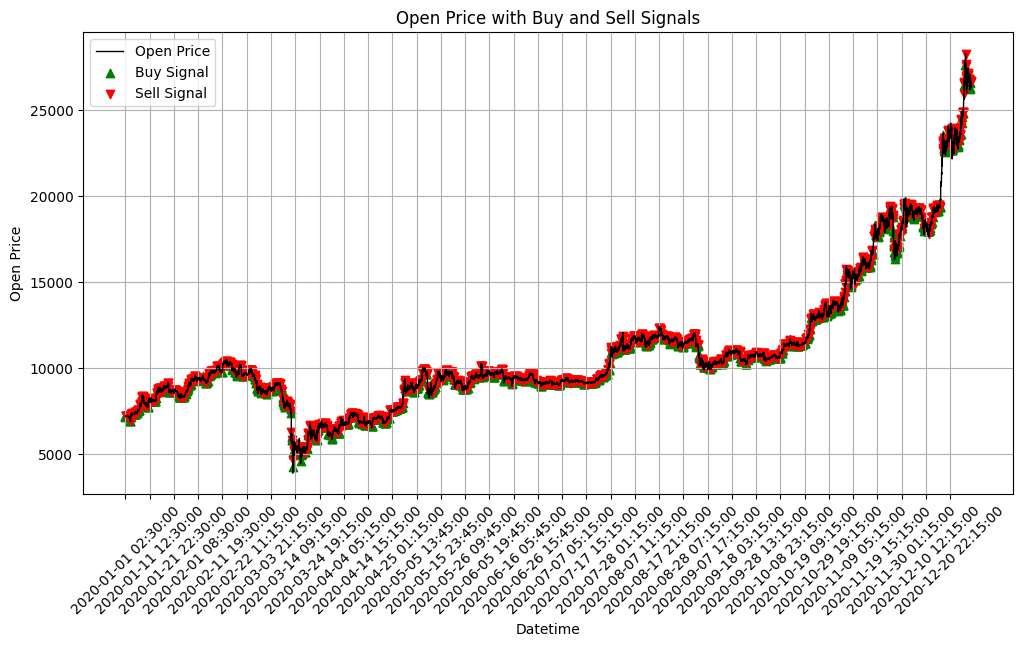

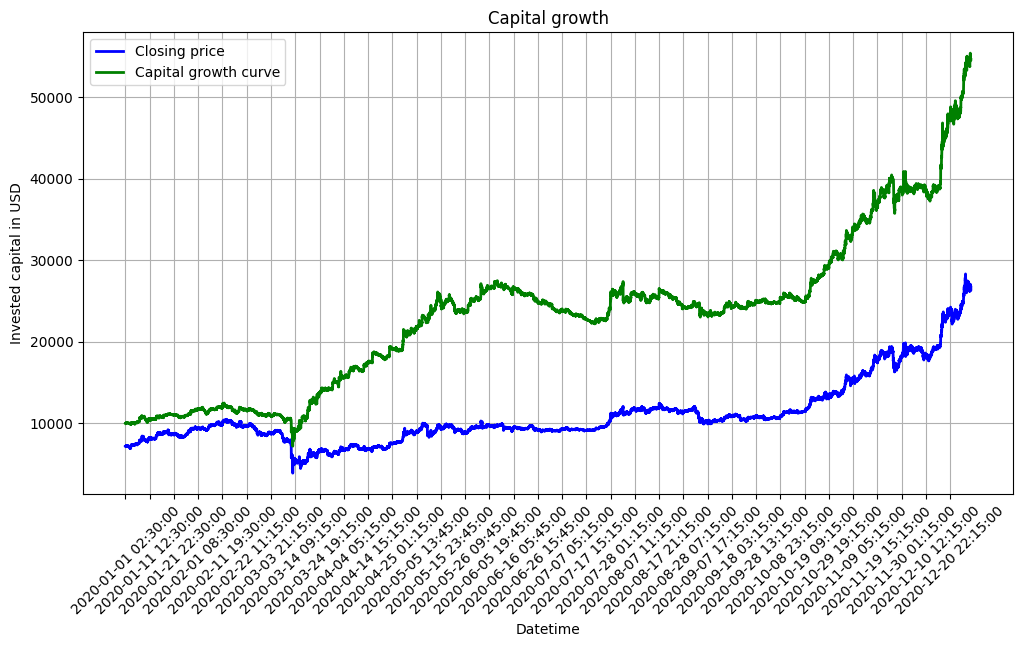

In [17]:
import matplotlib.pyplot as plt

plot_df = test_df.iloc[:]

# Your existing code for plotting open price with buy and sell signals
plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['open'], label='Open Price', linewidth=1, color='black')
plt.scatter(plot_df[plot_df['Signal'] == 'buy']['datetime'], plot_df[plot_df['Signal'] == 'buy']['open'], marker='^', color='g', label='Buy Signal')
plt.scatter(plot_df[plot_df['Signal'] == 'sell']['datetime'], plot_df[plot_df['Signal'] == 'sell']['open'], marker='v', color='r', label='Sell Signal')

plt.title('Open Price with Buy and Sell Signals')
plt.xlabel('Datetime')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)

# Set x-axis ticks to show every n-th date (adjust n as needed)
n = 1000
plt.xticks(plot_df['datetime'][::n], rotation=45)  # Adjust rotation for better visibility
plt.show()

# Plotting Equity Curve using the 'New_usd' column
plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['close'], label='Closing price', linewidth=2, color='blue')
plt.plot(plot_df['datetime'], plot_df['New_usd'], label='Capital growth curve', linewidth=2, color='green')

plt.title('Capital growth')
plt.xlabel('Datetime')
plt.ylabel('Invested capital in USD')
plt.legend()
plt.grid(True)

# Set x-axis ticks to show every n-th date (adjust n as needed)
plt.xticks(plot_df['datetime'][::n], rotation=45)  # Adjust rotation for better visibility
plt.show()
